In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import datetime
import sys
sys.path.append('..')
import src.tools as tools

#RFM Libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from datetime import datetime, timedelta,date
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

In [95]:
a = pd.read_csv('../data/Year 2009-2010.csv', encoding='unicode_escape')
b = pd.read_csv('../data/Year 2010-2011.csv', encoding='unicode_escape')
retail = pd.concat([a,b], ignore_index=True)

Prepare dataframe

In [96]:
retail.columns= retail.columns.str.lower()
retail.drop_duplicates(inplace=True)
retail = retail.query("country=='United Kingdom'").reset_index(drop=True)
retail.invoicedate = pd.to_datetime(retail.invoicedate)
retail['year'] = retail.invoicedate.dt.year
retail['month'] = retail.invoicedate.dt.month
retail['week'] = retail.invoicedate.dt.isocalendar().week
retail['day'] = retail.invoicedate.dt.day
retail['hour'] = retail.invoicedate.dt.hour
retail['revenue'] = retail.price * retail.quantity
retail = retail.query("year>2009").reset_index(drop=True)
retail = retail.query("quantity>0").reset_index(drop=True)
retail = retail.query("price>0").reset_index(drop=True)
retail = retail.dropna()

Define customers

In [97]:
min_date = retail.groupby(['customer id'])['invoicedate'].min().reset_index()
max_date = retail.groupby(['customer id'])['invoicedate'].max().reset_index()
min_date.columns = ['customer id', 'min_date']
max_date.columns = ['customer id', 'max_date']
min_date = pd.merge(min_date, max_date, on='customer id')
min_date['customer_months'] = min_date['max_date'] - min_date['min_date']
min_date['customer_months'] = min_date['customer_months'] / np.timedelta64(1,'M')
min_date['customer_months'] = min_date['customer_months'].astype(int)
min_date.drop(columns=['min_date','max_date'], inplace=True)
retail = pd.merge(retail, min_date, on='customer id')
retail.sample()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months
503196,567184,21977,PACK OF 60 PINK PAISLEY CAKE CASES,2,2011-09-18 15:41:00,0.55,16033.0,United Kingdom,2011,9,37,18,15,1.1,15


In [98]:
retail_lines = retail[['invoicedate','quantity','revenue']]
#'year','month','day','hour'
retail_lines.sample()

,invoicedate,quantity,revenue
234119,2010-07-19 12:26:00,2,14.98


In [ ]:
retail_lines.invoicedate = pd.to_datetime(retail_lines.invoicedate).dt.strftime('%Y-%m')
retail_lines

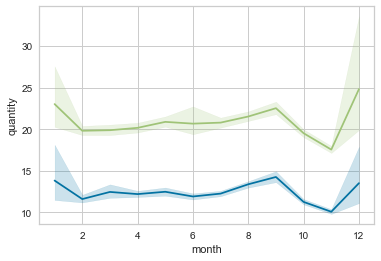

In [92]:
sns.lineplot(data=retail_lines, x='month', y='quantity')
sns.lineplot(data=retail_lines, x='month', y='revenue')
plt.show()

In [5]:
(retail.customer_months.value_counts(normalize=True)*100).sort_index()

0      5.924573
1      1.657938
2      1.658938
3      1.936355
4      1.731326
5      1.252020
6      1.343684
7      1.658367
8      1.966767
9      1.457335
10     1.591118
11     2.834143
12     3.810174
13     3.471504
14     2.956219
15     2.288731
16     3.080150
17     3.271615
18     3.580158
19     5.148575
20     6.626042
21     5.734393
22     6.366043
23    18.780590
24     9.873242
Name: customer_months, dtype: float64

Customers for RFM

In [6]:
retail_23 = retail.query('customer_months==23').reset_index(drop=True)
df_2y = tools.rfm(retail_23)
df_2y.sample()

,customer id,recency,frequency,monetary
35,15287.0,21,36,856.03


Drop outliers

In [7]:
df_2y['z_recency'] = stats.zscore(df_2y.recency)
df_2y['z_frequency'] = stats.zscore(df_2y.frequency)
df_2y['z_monetary'] = stats.zscore(df_2y.monetary)

df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,315.000000,315.000000,315.000000,315.000000,3.150000e+02,3.150000e+02
mean,12.965079,417.577778,9286.656797,0.000000,1.409807e-18,1.268826e-17
std,8.951144,433.869909,14959.406302,1.001591,1.001591e+00,1.001591e+00
min,0.000000,9.000000,229.500000,-1.450732,-9.432041e-01,-6.064123e-01
25%,6.000000,149.000000,2775.040000,-0.779360,-6.200133e-01,-4.359784e-01
50%,11.000000,271.000000,5115.760000,-0.219883,-3.383756e-01,-2.792579e-01
75%,20.000000,518.000000,9902.175000,0.787175,2.318253e-01,4.121136e-02
max,35.000000,2864.000000,147142.770000,2.465604,5.647579e+00,9.230009e+00


In [8]:

df_2y = df_2y[(df_2y.z_recency >= -3) & (df_2y.z_recency <= 3) &
         (df_2y.z_frequency >= -3) & (df_2y.z_frequency <= 3) &
         (df_2y.z_monetary >= -3) & (df_2y.z_monetary <= 3)]

df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,13.006623,377.910596,7012.606825,0.004648,-0.091572,-0.152257
std,8.958373,341.943005,6776.745802,1.002400,0.789377,0.453730
min,0.000000,9.000000,229.500000,-1.450732,-0.943204,-0.606412
25%,6.000000,145.000000,2753.925000,-0.779360,-0.629247,-0.437392
50%,12.000000,266.500000,4877.695000,-0.107988,-0.348764,-0.295197
75%,20.000000,493.000000,9027.152500,0.787175,0.174113,-0.017375
max,35.000000,1712.000000,43515.051000,2.465604,2.988181,2.291726


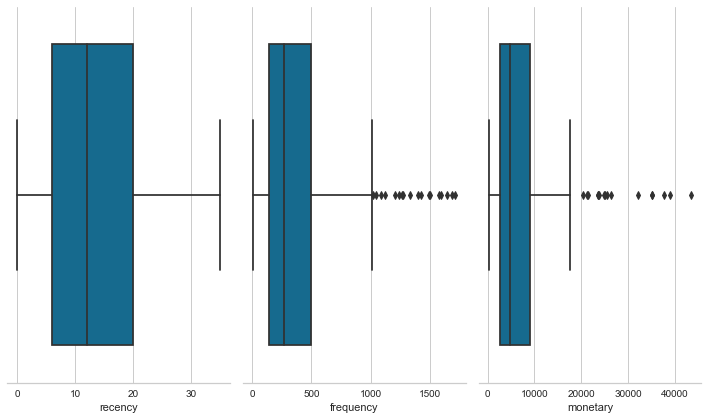

In [9]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.boxplot(x=df_2y.recency, color="b", ax=axes[0])
sns.boxplot(x=df_2y.frequency, color="b", ax=axes[1])
sns.boxplot(x=df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

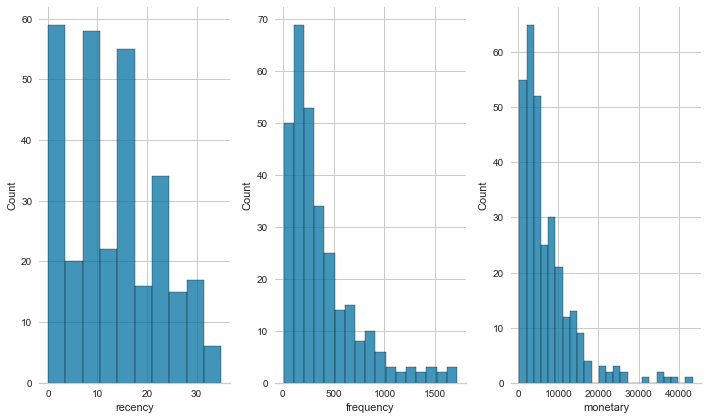

In [10]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.histplot(df_2y.recency, color="b", ax=axes[0])
sns.histplot(df_2y.frequency, color="b", ax=axes[1])
sns.histplot(df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

In [11]:
print(stats.jarque_bera(df_2y.recency)[1] < 0.05)
print(stats.jarque_bera(df_2y.frequency)[1] < 0.05)
print(stats.jarque_bera(df_2y.monetary)[1] < 0.05)

True
True
True


In [12]:
"""fig = plt.figure()

fig.set_size_inches(15, 15)

ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

ax.set_title("RFM Distribution")
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary")

ax.scatter(df_2y.recency,df_2y.frequency,df_2y.monetary, marker="x", c=df_2y.segment)

#ax.grid(False)

plt.show()""";

Elbow method to define K means

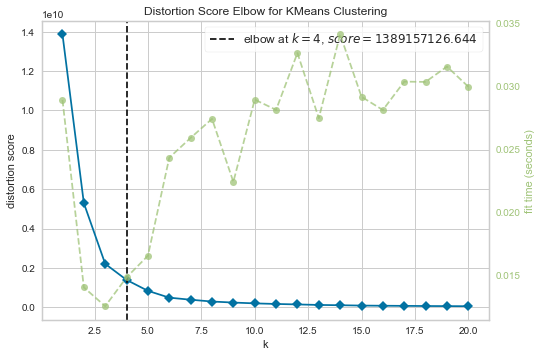

In [13]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,21))

visualizer.fit(df_2y[['recency', 'frequency', 'monetary']])
visualizer.show();

Kmeans analysis

In [14]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_2y[['recency', 'frequency', 'monetary']])
df_2y['clusters'] = kmeans.predict(df_2y[['recency', 'frequency', 'monetary']])
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters
27,14108.0,30,52,1044.96,1.906128,-0.843938,-0.551814,3
162,14285.0,20,61,3284.42,0.787175,-0.823162,-0.401873,3
96,17157.0,7,141,5151.90,-0.667464,-0.638481,-0.276838,3


In [15]:
(df_2y.clusters.value_counts(normalize=True)*100).sort_index()

0    28.807947
1     1.986755
2    11.258278
3    57.947020
Name: clusters, dtype: float64

In [16]:
df_2y.drop(columns='customer id').groupby(['clusters']).median()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
clusters,,,,,,
0,11.0,447.0,8706.97,-0.219883,0.067921,-0.038812
1,3.5,720.5,36437.86,-1.059098,0.699298,1.817880
2,10.0,692.5,16142.11,-0.331778,0.634659,0.459000
3,14.0,186.0,3082.10,0.115803,-0.534599,-0.415419


In [17]:
weighted = df_2y.drop(columns='customer id').groupby(['clusters']).median()
weighted['recency'] = weighted['recency']/weighted['recency'].min()
weighted['frequency'] = weighted['frequency']/weighted['frequency'].max()
weighted['monetary'] = weighted['monetary']/weighted['monetary'].max()
weighted['segment'] = (weighted.frequency * weighted.monetary) / weighted.recency
weighted['segment'] = weighted.segment.rank(ascending=False)
weighted.sort_values(by='segment')

,recency,frequency,monetary,z_recency,z_frequency,z_monetary,segment
clusters,,,,,,,
1,1.000000,1.000000,1.000000,-1.059098,0.699298,1.817880,1.0
2,2.857143,0.961138,0.443004,-0.331778,0.634659,0.459000,2.0
0,3.142857,0.620402,0.238954,-0.219883,0.067921,-0.038812,3.0
3,4.000000,0.258154,0.084585,0.115803,-0.534599,-0.415419,4.0


In [18]:
df_2y = pd.merge(df_2y, weighted['segment'], on='clusters')
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters,segment
237,13953.0,6,25,6640.68,-0.779360,-0.906268,-0.177159,0,3.0
123,15494.0,20,368,3702.60,0.787175,-0.114451,-0.373875,3,4.0
286,18172.0,14,475,17467.24,0.115803,0.132560,0.547722,2,2.0


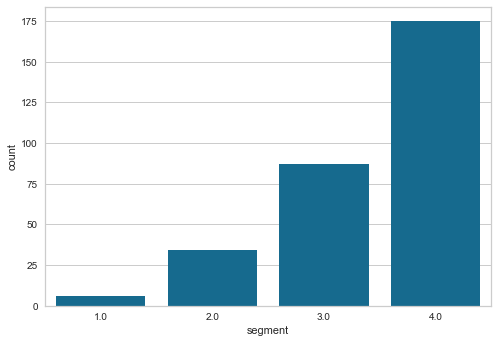

In [19]:
sns.countplot(x=df_2y.segment, color="b");

In [20]:
(df_2y.segment.value_counts(normalize=True)*100).sort_index(ascending=True)

1.0     1.986755
2.0    11.258278
3.0    28.807947
4.0    57.947020
Name: segment, dtype: float64

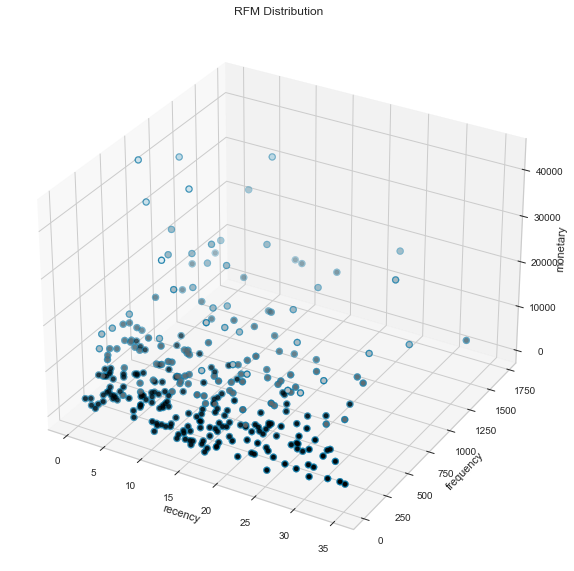

In [40]:
fig = plt.figure()

fig.set_size_inches(10, 10)

ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

ax.set_title("RFM Distribution")
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary")

ax.scatter(df_2y.recency,df_2y.frequency,df_2y.monetary, c=df_2y.segment, )

colormap='Blues'

#ax.grid(False)


plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/ironhack/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


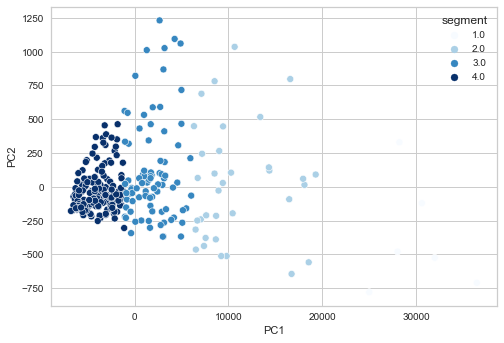

In [35]:
pca = PCA(2)
data_t = pd.DataFrame(pca.fit_transform(df_2y.drop(columns='customer id')), columns=["PC1", "PC2"])

sns.scatterplot(data_t["PC1"],data_t["PC2"], hue=df_2y['segment'], palette='Blues');

In [23]:
retail2y = pd.merge(retail_23, df_2y[['customer id', 'segment']], on='customer id')
retail2y.sample(3)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months,segment
67397,550633,23153,ZINC SWEETHEART WIRE LETTER RACK,2,2011-04-19 14:57:00,3.75,17449.0,United Kingdom,2011,4,16,19,14,7.5,23,4.0
21790,507176,22382,LUNCH BAG SPACEBOY DESIGN,10,2010-05-06 15:05:00,1.65,17069.0,United Kingdom,2010,5,18,6,15,16.5,23,4.0
92367,533569,22065,CHRISTMAS PUDDING TRINKET POT,4,2010-11-18 10:33:00,1.45,14796.0,United Kingdom,2010,11,46,18,10,5.8,23,3.0


Forecast customers behavior

In [24]:
#retail2y.groupby(['year','month','segment'])['revenue'].sum().unstack().fillna(0)

Time series

In [25]:
retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()

cluster1 = retail2y[retail2y.segment == 1]
cluster1 = cluster1[['invoicedate', 'revenue']]

cluster2 = retail2y[retail2y.segment == 2]
cluster2 = cluster2[['invoicedate', 'revenue']]

cluster3 = retail2y[retail2y.segment == 3]
cluster3 = cluster3[['invoicedate', 'revenue']]

cluster4 = retail2y[retail2y.segment == 4]
cluster4 = cluster4[['invoicedate', 'revenue']]

In [26]:
retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()

cluster11 = retail2y[retail2y.segment == 1]
cluster11 = cluster11[['invoicedate', 'quantity']]

cluster22 = retail2y[retail2y.segment == 2]
cluster22 = cluster22[['invoicedate', 'quantity']]

cluster33 = retail2y[retail2y.segment == 3]
cluster33 = cluster33[['invoicedate', 'quantity']]

cluster44 = retail2y[retail2y.segment == 4]
cluster44 = cluster44[['invoicedate', 'quantity']]

def clean_ts (df):
    df.columns = ['ds','y']
    df.ds = pd.to_datetime(df.ds).dt.strftime('%Y-%m')
    #df['z_score'] = stats.zscore(df.y)
    #df = df[(df.z_score >= -3) & (df.z_score <= 3)]
    #df = df.drop(columns='z_score')"""
    df.set_index('ds', inplace=True)
    return df

Export

In [27]:
cluster1.to_csv('../data/ts_segment1.csv',index=False)
cluster2.to_csv('../data/ts_segment2.csv',index=False)
cluster3.to_csv('../data/ts_segment3.csv',index=False)
cluster4.to_csv('../data/ts_segment4.csv',index=False)

In [28]:
cluster11.to_csv('../data/ts_segment11.csv',index=False)
cluster22.to_csv('../data/ts_segment22.csv',index=False)
cluster33.to_csv('../data/ts_segment33.csv',index=False)
cluster44.to_csv('../data/ts_segment44.csv',index=False)